# Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib as mpl

# Random Seed

In [2]:
np.random.seed(111)
random.seed(111)

# Grid Environment

In [3]:
class GridWorld():

    """ 
    This is a 7 x 7 grid where an agent can take a random walk. That is, the agent is equally likely to
    move up, down, left, or right. Suppose that the agent start the random walk at the precise center of 
    the grid. We assume that the lower left and upper right corners are terminal states, with, respectively, rewards
    of -1 and 1. Rewards for transitions between two states are 0, if an attempt to transition outside the
    wall is made, the agent stays in the same spot and receives a reward of 0.

    """

    # parameters
    def __init__(self):

        # grid size (row, col)
        self.gridsize = (7, 7)

        # all states
        self.state_space = [(row, col) for row in range(self.gridsize[0])
                            for col in range(self.gridsize[1])]
        
        # all actions
        self.action_space = ['up', 'down', 'left', 'right']

        # effect of action on row and col
        self.action_delta = {
            'up': (-1, 0),
            'down': (1,0),
            'left': (0, -1),
            'right': (0, 1)
            } 
        
        # start state
        self.start_state = (3, 3)

        # terminal state
        self.end_state = [(6, 0), (0, 6)]
    

    # start state
    def reset(self):
        return self.start_state
    
    # terminal state
    def isTerminal(self, state):
        return state in self.end_state
    
    # get next state and reward (For sample generation)
    def nextStateReward(self, state, action):
        delta = self.action_delta[action]
        next_state = (state[0] + delta[0], state[1] + delta[1])

        if self.isTerminal(next_state):
            if next_state == (6, 0):
                reward = -1
            else:
                reward = 1
            return (next_state, reward)
        
        # check if next state is within the grid
        elif 0 <= next_state[0] < self.gridsize[0] and 0 <= next_state[1] < self.gridsize[1]:
            reward = 0
            return (next_state, reward)
        else:
            reward = 0
            return(state, reward)
        
    
    # For MDP with transition probability
    def nextStateProbReward(self, state, action):

        # placeholder for all possible (next state, transition probability, reward)
        result = []

        # get next state based on action
        delta = self.action_delta[action]
        next_state = (state[0] + delta[0], state[1] + delta[1])

        # for all states as possible next states
        for s_prime in self.state_space:

            # for terminal state as next state
            if self.isTerminal(next_state):
                if next_state == (6, 0):
                    reward = -1
                else:
                    reward = 1
                if s_prime == next_state:
                    prob = 1
                    result.append((s_prime, prob, reward))
                else:
                    prob = 0
                    reward = 0
                    result.append((s_prime, prob, reward))

            # other states as next state
            else:
                 # check if next state is within the grid
                if 0 <= next_state[0] < self.gridsize[0] and 0 <= next_state[1] < self.gridsize[1]:
                    if s_prime == next_state:
                        prob = 1
                        reward = 0
                        result.append((s_prime, prob, reward))
                    else:
                        prob = 0
                        reward = 0
                        result.append((s_prime, prob, reward))
                else:
                    if s_prime == state:
                        prob = 1 
                        reward = 0
                        result.append((state, prob, reward))
                    else:
                        prob = 0     
                        reward = 0 
                        result.append((state, prob, reward))

        return result

# Exact Value Function

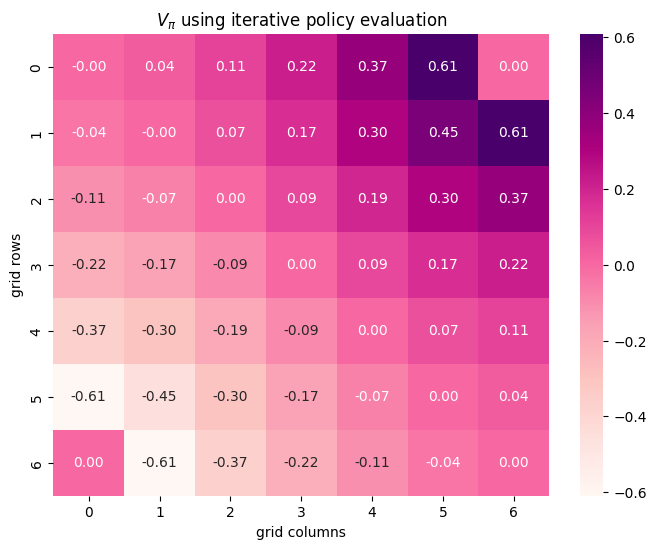

In [4]:
def iterativePolicyEvaluation(mdp): 

    # equiprobable move policy
    action_probs = {}
    for state in mdp.state_space:
        for action in mdp.action_space:
            action_probs[(state, action)] = 1/len(mdp.action_space)
    
    # convergence threshold
    threshold = 1e-10   

    # convergence parameter
    delta = 1 

    # discount rate for future returns
    gamma = 1

    V = np.zeros(mdp.gridsize)

    # help function to obtain state-action value
    def Q(state, action): 
        return sum(prob * (reward + gamma * V[next_state]) \
                    for next_state, prob, reward in mdp.nextStateProbReward(state, action))

    while delta > threshold:
        delta = 0
        for state in mdp.state_space: 
            # for nonterminal states
            if not mdp.isTerminal(state):
                # old value function
                v = V[state]   

                # initialise new value function
                new_V = 0   
                for action in mdp.action_space:
                    new_V += action_probs[(state, action)]* Q(state, action)
                
                # update the value function
                V[state] = new_V 
                delta = max(delta, abs(v - V[state])) 

    return V 

# implement iterative policy evaluation
mdp = GridWorld()
V_exact = iterativePolicyEvaluation(mdp= mdp)

# visualize the value function
plt.figure(figsize=(8,6))
cmap = mpl.colormaps['RdPu']
sns.heatmap(V_exact, annot=True, fmt=".2f", cmap= cmap, cbar=True)
plt.title('$V_{\pi}$ using iterative policy evaluation')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show()

# Gradient Monte Carlo

# a. gradient MC

In [5]:
def gradientMonteCarlo(mdp, alpha, num_episode):

    # feature space X(st) using one-hot encoding
    def featureVector(state):
        size = mdp.gridsize[0]
        features = np.zeros(size * size)
        state_position = state[0] * size + state[1]
        features[state_position] = 1
        return features
    
    # feature space X(st) using radial basis function
    def rbf(state):
        sigma = 1.0
        state = np.array(state)
        centroids = np.array(mdp.state_space)
        features = np.exp(-np.linalg.norm(state - centroids, axis= 1)**2 / (2 * sigma ** 2))
        return features

    
    # weights and bias
    weights = np.zeros(mdp.gridsize[0] * mdp.gridsize[1])

    b = np.random.randn()

    # function to obtain the value function 
    def valueFunction(weights, state):
        return np.dot(weights, featureVector(state)) + b

    # error for each episode
    rmse = []

    # discount rate    
    gamma = 1

    # equiprobable move policy
    policy = {}
    for state in mdp.state_space:
        policy[state] = [1/len(mdp.action_space)]*len(mdp.action_space)


    for _ in range(num_episode):

        start_state= mdp.reset()

        # placeholder for episode samples
        trajectory = []

        state = start_state

        # generate episode
        while True:
            # select action based on policy
            action_probs = policy[state]
            action = mdp.action_space[np.random.choice(len(mdp.action_space), p= action_probs)]

            # obtain next state and reward
            next_state, reward = mdp.nextStateReward(state, action)

            # get samples
            trajectory.append((state, action, reward))

            # update state
            state = next_state

            # terminate epsiode
            if mdp.isTerminal(state):
                break
        
        G = 0
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward

            # obtain the approximate value function V(s, w) based on weights, w
            if state not in [x[0] for x in trajectory[:t]]:
                feature_vector = featureVector(state)
                V_s = np.dot(weights, feature_vector) + b

                # use SGD to update the weights
                weights += alpha * (G - V_s) * feature_vector
                b += alpha * (G - V_s)
        
        # obtain value function to get the error
        V = np.zeros(mdp.gridsize)
        for state in mdp.state_space:
            if not mdp.isTerminal(state):
                V[state] = valueFunction(weights= weights, state= state)
        
        episodic_rmse = np.sqrt(np.mean((V_exact - V)**2))
        rmse.append(episodic_rmse)

    return V, rmse

# b. optimizing step Size for gradient MC

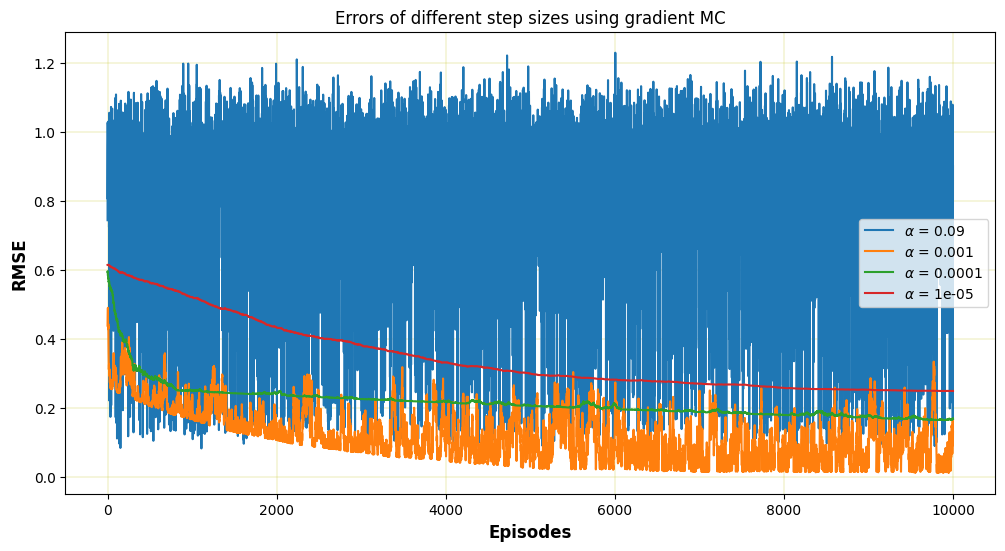

In [6]:
mdp = GridWorld()

# setep sizes
alphas = [0.09, 0.001, 0.0001, 0.00001]

# placeholder for RMSE of each step size
errors = []

# obtain error
for alpha in alphas:
    _, error = gradientMonteCarlo(mdp, alpha, num_episode= 10000)
    errors.append(error)

# plot
plt.figure(figsize= (12, 6))
plt.plot(errors[0], label = '$\\alpha$ = {}'.format(alphas[0]))
plt.plot(errors[1], label = '$\\alpha$ = {}'.format(alphas[1]))
plt.plot(errors[2], label = '$\\alpha$ = {}'.format(alphas[2]))
plt.plot(errors[3], label = '$\\alpha$ = {}'.format(alphas[3]))
plt.xlabel('Episodes', fontsize = 12, weight = 'bold')
plt.ylabel('RMSE', fontsize = 12, weight = 'bold')
plt.grid(color = 'y', linewidth = 0.2)
plt.title('Errors of different step sizes using gradient MC')
plt.legend()
plt.show()


# c. implementing gradient MC

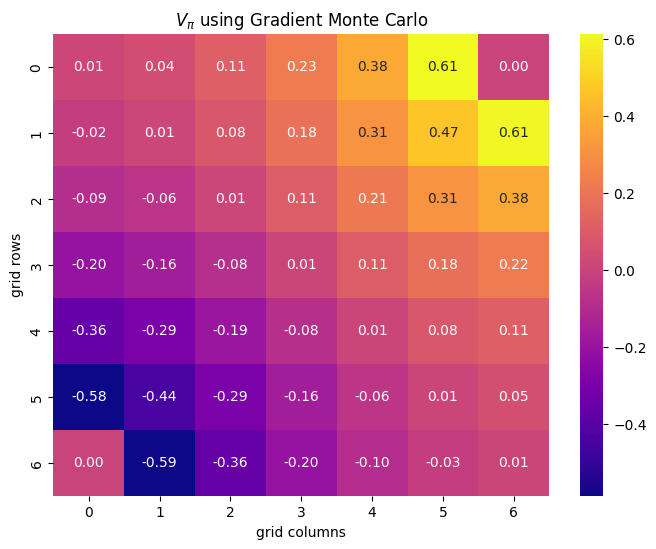

In [7]:
# implement gradient monte carlo
mdp = GridWorld()
num_episode = 90000
alpha = 0.0001

value_function, error_mc = gradientMonteCarlo(mdp= mdp,
                                              alpha= alpha,
                                              num_episode= num_episode
                                              )


# visualize the value function
plt.figure(figsize=(8, 6))
cmap = mpl.colormaps['plasma']
sns.heatmap(value_function, annot=True, fmt=".2f", cmap= cmap, cbar=True)
plt.title('$V_{\pi}$ using Gradient Monte Carlo')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show() 

# Semi-gradient TD(0)

# a. semi-gradientTD(0) Method

In [8]:
def semiGradientTD(mdp, alpha, num_episode):

    # feature space X(st) using one-hot encoding
    def featureVector(state):
        size = mdp.gridsize[0]
        features = np.zeros(size * size)
        state_position = state[0] * size + state[1]
        features[state_position] = 1
        return features
    
    # feature space X(st) using radial basis function
    def rbf(state):
        sigma = 1.0
        state = np.array(state)
        centroids = np.array(mdp.state_space)
        features = np.exp(-np.linalg.norm(state - centroids, axis= 1)**2 / (2 * sigma ** 2))
        return features

    
    # weights and bias
    weights = np.zeros(mdp.gridsize[0] * mdp.gridsize[1])
    b = 0

    # obtain the value function 
    def valueFunction(weights, state):
        return np.dot(weights, featureVector(state)) + b

    # discount rate    
    gamma = 1

    # error for each episode
    rmse = []

    # equiprobable move policy
    policy = {}
    for state in mdp.state_space:
        policy[state] = [1/len(mdp.action_space)]*len(mdp.action_space)


    for _ in range(num_episode):
        start_state= mdp.reset()

        # initialize state
        state = start_state

        # generate episode
        while True:
            # select action based on policy
            action_probs = policy[state]
            action = mdp.action_space[np.random.choice(len(mdp.action_space), p= action_probs)]

            # obtain next state and reward
            next_state, reward = mdp.nextStateReward(state, action)

            # obtain state and next state estimates
            state_estimate = valueFunction(weights, state)
            next_state_estimate = valueFunction(weights, next_state)

            # obtain error
            td_error = reward + gamma * next_state_estimate - state_estimate

            # update weights and b
            weights += alpha * td_error * featureVector(state)
            b += alpha * td_error

            # update state
            state = next_state

            # terminate
            if mdp.isTerminal(state):
                break
    
        # obtain value function and error
        V = np.zeros(mdp.gridsize)
        for state in mdp.state_space:
            if not mdp.isTerminal(state):
                V[state] = valueFunction(weights= weights, state= state)
        
        episodic_rmse = np.sqrt(np.mean((V_exact - V)**2))
        rmse.append(episodic_rmse)
            

    return V, rmse 

# b. optimizing step size for semi-gradient TD(0) method

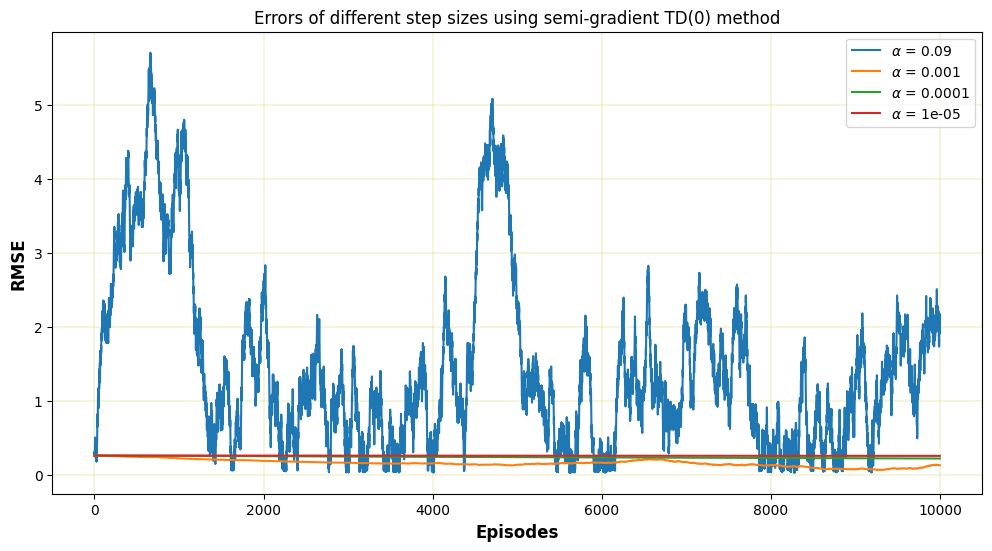

In [9]:
mdp = GridWorld()

# setep sizes
alphas = [0.09, 0.001, 0.0001, 0.00001]

# placeholder for RMSE of each step size
errors = []

# obtain error
for alpha in alphas:
    _, error = semiGradientTD(mdp, alpha, num_episode= 10000)
    errors.append(error)

# plot
plt.figure(figsize= (12, 6))
plt.plot(errors[0], label = '$\\alpha$ = {}'.format(alphas[0]))
plt.plot(errors[1], label = '$\\alpha$ = {}'.format(alphas[1]))
plt.plot(errors[2], label = '$\\alpha$ = {}'.format(alphas[2]))
plt.plot(errors[3], label = '$\\alpha$ = {}'.format(alphas[3]))
plt.xlabel('Episodes', fontsize = 12, weight = 'bold')
plt.ylabel('RMSE', fontsize = 12, weight = 'bold')
plt.grid(color = 'y', linewidth = 0.2)
plt.legend()
plt.title('Errors of different step sizes using semi-gradient TD(0) method')
plt.show()

# c. implementing semi-gradient TD(0)

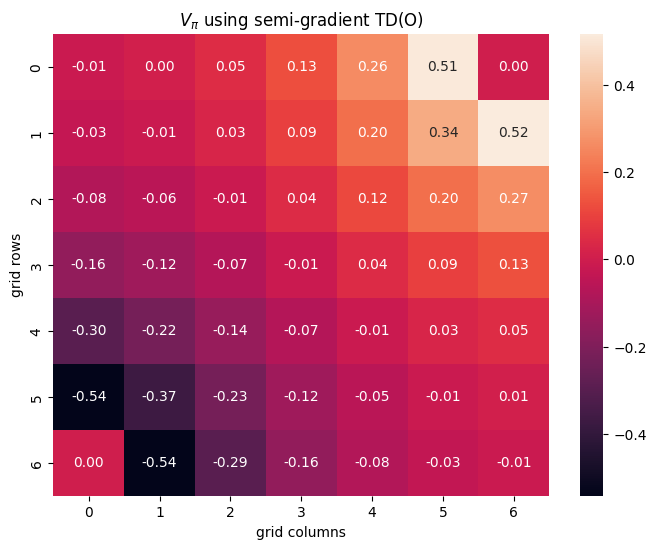

In [10]:
# implement gradient monte carlo
mdp = GridWorld()
num_episode = 90000
alpha = 0.0001

value_function, error_td = semiGradientTD(mdp= mdp,
                                          alpha= alpha,
                                          num_episode= num_episode
                                          )


# visualize the value function
plt.figure(figsize=(8, 6))
sns.heatmap(value_function, annot=True, fmt=".2f", cbar=True)
plt.title('$V_{\pi}$ using semi-gradient TD(O)')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show()

# Methods Comparison

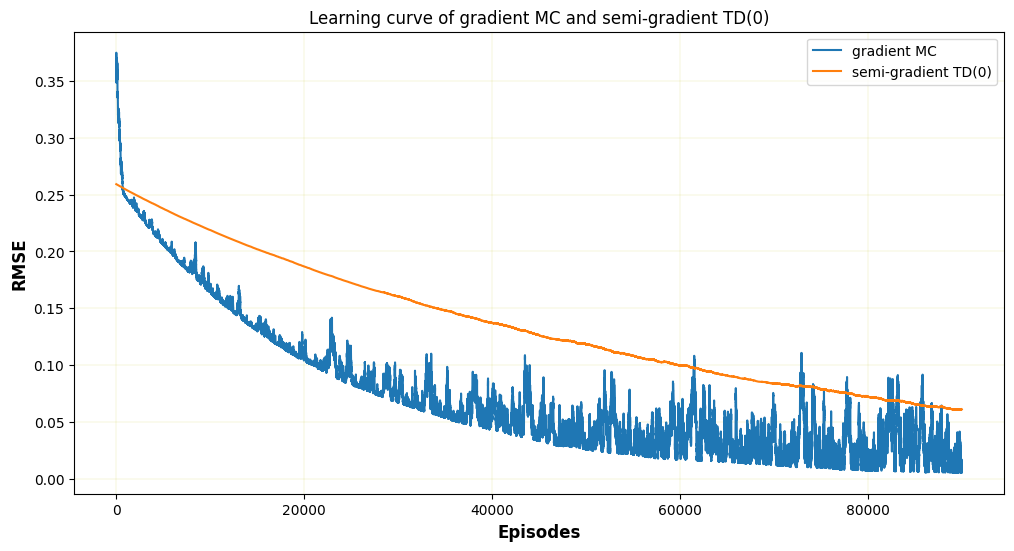

In [11]:
# obtain the minimum number of episode
size = min(len(error_td), len(error_mc))

# plot root mean squared error
plt.figure(figsize= (12, 6))
plt.plot(error_mc[:size], label = 'gradient MC')
plt.plot(error_td[:size], label = 'semi-gradient TD(0)')
plt.xlabel('Episodes', fontsize = 12, weight = 'bold')
plt.ylabel('RMSE', fontsize = 12, weight = 'bold')
plt.grid(color = 'y', linewidth = 0.1)
plt.legend()
plt.title('Learning curve of gradient MC and semi-gradient TD(0)')
plt.show()